# Get Whataburger locations

#### Load Python tools and Jupyter config

In [1]:
%load_ext lab_black

In [2]:
import pandas as pd
import os
import requests
import json

os.environ["USE_PYGEOS"] = "0"
import geopandas as gpd
from bs4 import BeautifulSoup
from tqdm.notebook import tqdm, trange

In [3]:
pd.options.display.max_columns = 100
pd.options.display.max_rows = 1020
pd.options.display.max_colwidth = None

---

## Scrape

#### Headers for requests

In [4]:
headers = {
    "User-Agent": "Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/84.0.4147.89 Safari/537.36"
}

#### Read store list page

In [5]:
url = "https://locations.whataburger.com/directory.html"
response = requests.get(url, headers=headers)
soup = BeautifulSoup(response.text, "html.parser")

#### Find all the state links in the directory and store them in a list

In [6]:
locations_list = []

for a in tqdm(soup.findAll("a", class_="Directory-listLink")):
    locations_dict = {
        "url": (
            "https://locations.whataburger.com/" + a["href"].split("/", 1)[0] + ".html"
        ).replace(".html.html", ".html"),
        "state": a.text,
    }
    locations_list.append(locations_dict)
locations_df = pd.DataFrame(locations_list)

  0%|          | 0/17 [00:00<?, ?it/s]

#### Loop through every state, snagging links to cities

In [7]:
city_dir_list = []

for s in tqdm(locations_df["url"].to_list()):
    city_response = requests.get(s, headers=headers)
    city_soup = BeautifulSoup(city_response.text, "html.parser")
    city_directory = city_soup.findAll("li", class_="Directory-listItem")
    for t in city_directory:
        city_dir_dict = {
            "url": "https://locations.whataburger.com/" + t.find("a")["href"],
            "city": t.text.title(),
            "count": t.find("span")
            .attrs["data-count"]
            .replace("(", "")
            .replace(")", ""),
        }
        city_dir_list.append(city_dir_dict)

  0%|          | 0/17 [00:00<?, ?it/s]

In [8]:
city_dir_src = pd.DataFrame(city_dir_list)

#### Some cities have multiple restaurants. Others have just one (single) link. 

In [9]:
city_dir_df_plural = city_dir_src.query('count > "1"')
city_dir_df_single = city_dir_src.query('count == "1"')

#### Loop through those with one or more places (plural) and get links to individual restaurants

In [10]:
plural_list = []

for p in tqdm(city_dir_df_plural["url"].to_list()):
    plural_response = requests.get(p, headers=headers)
    plural_soup = BeautifulSoup(plural_response.text, "html.parser")
    plural_directory = plural_soup.findAll("div", class_="Teaser-row Teaser-row--info")
    for pld in plural_directory:
        plural_list.append(
            "https://locations.whataburger.com"
            + pld.find("a", class_="Teaser-titleLink")["href"].replace("..", "")
        )

  0%|          | 0/133 [00:00<?, ?it/s]

#### Create two lists of the single and plural places, and merge them

In [11]:
single_list = city_dir_df_single["url"].to_list()

In [12]:
location_url_list = plural_list + single_list

#### Loop through that list, snagging details about each location

In [13]:
lul_list = []

for lul in tqdm(location_url_list):
    lul_response = requests.get(lul, headers=headers)
    lul_soup = BeautifulSoup(lul_response.text, "html.parser")
    lul_dict = {
        "id": lul_soup.find("h1").text.replace("Welcome to Whataburger ", ""),
        "location": lul_soup.find("span", class_="Banner-titleGeo").text,
        "street": lul_soup.find("span", class_="c-address-street-1").text.title(),
        "city": lul_soup.find("span", class_="c-address-city").text.title(),
        "state": lul_soup.find("span", class_="c-address-state").text.title(),
        "zipcode": lul_soup.find("span", class_="c-address-postal-code").text.title(),
        "phone": lul_soup.find(
            "div", class_="Phone-display Phone-display--withLink"
        ).text.title(),
        "latitude": json.loads(
            lul_soup.findAll("script", class_="js-map-data")[0].text
        )["latitude"],
        "longitude": json.loads(
            lul_soup.findAll("script", class_="js-map-data")[0].text
        )["longitude"],
        "url": lul,
    }
    lul_list.append(lul_dict)

  0%|          | 0/1009 [00:00<?, ?it/s]

#### Make a dataframe with each location

In [14]:
df = pd.DataFrame(lul_list)

In [22]:
df.head()

,id,location,street,city,state,zipcode,phone,latitude,longitude,url
0,#1116,HWY 280 & Resource Center,111 Resource Center Pkwy,Birmingham,Alabama,35242,(205) 980-9315,33.425566,-86.705371,https://locations.whataburger.com/al/birmingham/111-resource-center-pkwy.html
1,# 896,CR 10 & Trussville,5931 Trussville Crossings Pkwy,Birmingham,Alabama,35235,(205) 655-4513,33.642994,-86.625934,https://locations.whataburger.com/al/birmingham/5931-trussville-crossings-pkwy.html
2,#1203,Memorial Pkwy & Hobbs Rd,11701 S Memorial Pkwy,Huntsville,Alabama,35803,(256) 203-8030,34.617277,-86.566448,https://locations.whataburger.com/al/huntsville/11701-s-memorial-pkwy.html
3,#1249,Friendship Commons & Winchester Road NE,2056 Winchester Road Ne,Huntsville,Alabama,35811,(256) 217-4249,34.815141,-86.498209,https://locations.whataburger.com/al/huntsville/2056-winchester-road-ne.html
4,#1236,,5900 University Dr Nw,Huntsville,Alabama,35806,(256) 417-6578,34.742133,-86.665901,https://locations.whataburger.com/al/huntsville/5900-university-dr-nw.html


## Geography

#### Geodataframe from lon/lat

In [16]:
gdf = gpd.GeoDataFrame(
    df, geometry=gpd.points_from_xy(df.longitude, df.latitude), crs="EPSG:4326"
)

#### Plot it

<AxesSubplot: >

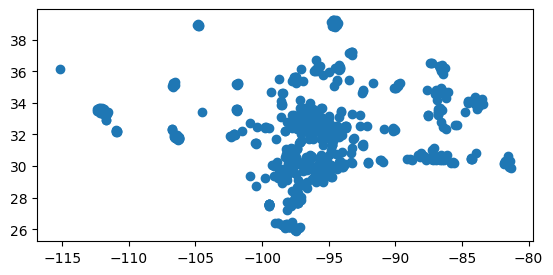

In [17]:
gdf.plot()

In [18]:
df = df.drop(["geometry"], axis=1)

---

## Exports

In [19]:
gdf.to_file("data/processed/whataburger.geojson", driver="GeoJSON")

In [20]:
df.to_json("data/processed/whataburger.json", orient="records", indent=4)

In [21]:
df.to_csv("data/processed/whataburger.csv", index=False)